In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve,validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,auc,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,KFold


from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier,callback
from catboost import Pool,metrics,cv,MetricVisualizer
from catboost.utils import get_roc_curve,select_threshold,get_fpr_curve,get_fnr_curve
from catboost import CatBoostClassifier,CatBoostRegressor
import shap

In [3]:
def reduce_mem_usage(data):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = data.memory_usage().sum() 
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else:
            data[col] = data[col].astype('category')
    end_mem = data.memory_usage().sum() 
    return data 

In [ ]:
train_df = reduce_mem_usage(pd.read_csv( './data/train.csv',encoding='utf-8'))
test_df = reduce_mem_usage(pd.read_csv( './data/test.csv',encoding='utf-8'))

In [8]:
train_data = pd.read_csv('./user_recommend/train_feature3.csv')
test_data = pd.read_csv('./user_recommend/test_feature3.csv')

In [9]:
train_data

,brand,model,province,city,first_year,last_year,session_count,active_days,dif_days_total,dif_days_avg,...,month_11.0_count,month_12.0_count,dayofweek_0.0_count,dayofweek_1.0_count,dayofweek_2.0_count,dayofweek_3.0_count,dayofweek_4.0_count,dayofweek_5.0_count,dayofweek_6.0_count,label
0,0,0,0,0,1,0,30,11,249.0,22.64,...,1.0,5.0,4.0,8.0,3.0,0.0,1.0,1.0,13.0,0.0
1,1,1,1,1,-1,-1,-1,-1,-1.0,-1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,2,2,1,0,61,20,337.0,16.84,...,5.0,10.0,10.0,16.0,19.0,8.0,2.0,0.0,6.0,0.0
3,3,3,3,3,0,0,2,1,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
4,3,4,4,4,1,0,50,11,349.0,31.73,...,0.0,0.0,16.0,2.0,0.0,2.0,22.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209465,7,285,7,250,1,1,4,1,0.0,0.00,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209466,3,28,15,223,0,0,2,1,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
209467,4,122,24,57,1,0,6,2,214.0,107.00,...,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
209468,3,233,22,148,4,4,54,2,25.0,12.50,...,0.0,0.0,42.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0


In [12]:
train_data.columns

Index(['brand', 'model', 'province', 'city', 'first_year', 'last_year',
       'session_count', 'active_days', 'dif_days_total', 'dif_days_avg',
       'day_sessions_avg', '2023_session_count', '2023_active_days',
       '2023_recency', '2023_dif_days_total', '2023_dif_days_avg',
       '2023_day_sessions_avg', 'year_2009.0_count', 'year_2010.0_count',
       'year_2015.0_count', 'year_2017.0_count', 'year_2018.0_count',
       'year_2019.0_count', 'year_2020.0_count', 'year_2021.0_count',
       'year_2022.0_count', 'year_2023.0_count', 'month_1.0_count',
       'month_2.0_count', 'month_3.0_count', 'month_4.0_count',
       'month_5.0_count', 'month_6.0_count', 'month_7.0_count',
       'month_8.0_count', 'month_9.0_count', 'month_10.0_count',
       'month_11.0_count', 'month_12.0_count', 'dayofweek_0.0_count',
       'dayofweek_1.0_count', 'dayofweek_2.0_count', 'dayofweek_3.0_count',
       'dayofweek_4.0_count', 'dayofweek_5.0_count', 'dayofweek_6.0_count',
       'label'],
     

In [10]:
test_data

,brand,model,province,city,first_year,last_year,session_count,active_days,dif_days_total,dif_days_avg,...,month_10.0_count,month_11.0_count,month_12.0_count,dayofweek_0.0_count,dayofweek_1.0_count,dayofweek_2.0_count,dayofweek_3.0_count,dayofweek_4.0_count,dayofweek_5.0_count,dayofweek_6.0_count
0,2,103,24,136,1,1,2,1,0.0,0.00,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,283,20,227,1,0,48,19,221.0,11.63,...,3.0,3.0,4.0,6.0,11.0,11.0,3.0,14.0,0.0,3.0
2,11,828,4,17,-1,-1,-1,-1,-1.0,-1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,223,21,84,1,0,10,3,253.0,84.30,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0
4,0,385,18,102,-1,-1,-1,-1,-1.0,-1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490525,340,1996,5,5,-1,-1,-1,-1,-1.0,-1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490526,3,34,5,56,1,1,1,1,0.0,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
490527,2,254,30,300,1,1,1,1,0.0,0.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
490528,3,121,29,98,1,0,39,15,254.0,16.94,...,1.0,3.0,7.0,0.0,3.0,2.0,3.0,3.0,16.0,12.0


In [13]:
x = train_data.drop('label',axis=1)
y = train_data['label']

## 特征选择

In [16]:
# 划分训练数据集，并进行训练

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=88)
train_set = lgb.Dataset(x_train,y_train)
val_set = lgb.Dataset(x_val,y_val)

callbacks = [callback.log_evaluation(period=1000,show_stdv=True),
            callback.early_stopping(stopping_rounds=200)]

param = {
        'objective':'binary',
        'boosting_type': 'gbdt',
        'learning_rate':0.02,
        'tree_learner':'serial',
        'metric':'auc',
        'max_depth':-1,
        'num_leaves':31,
        'reg_alpha':0,
        'reg_lambda':0,
        'subsample':0.9,
        'colsample_bytree':0.9,
        'random_seed':88,
        'silent':True,
        'verbose':-1, 
        }
model = lgb.train(param,train_set,num_boost_round=20000,valid_sets=val_set,callbacks=callbacks)

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.905412
Early stopping, best iteration is:
[1735]	valid_0's auc: 0.905697


### 模型预测评估，绘制roc曲线

未调参前lgbm单模型在验证集上的AUC：0.9056971055577325


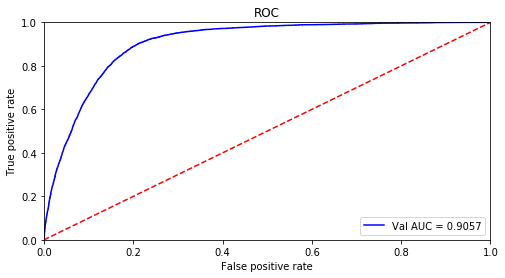

In [25]:
val_pred = model.predict(x_val,num_iteration=model.best_iteration)
fpr,tpr,threshold = roc_curve(y_val,val_pred)
roc_auc = auc(fpr,tpr)
print('未调参前lgbm单模型在验证集上的AUC：{}'.format(roc_auc))

plt.figure(figsize=(8,4))
plt.title('Validation ROC')
plt.plot(fpr,tpr,'b',label='Val AUC = %0.4f' % roc_auc)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot([0,1],[0,1],'r--')
plt.show()


### 使用5折交叉验证进行模型性能评估

In [29]:
folds = KFold(n_splits=3,shuffle=True,random_state=88)
prediction_lgbm = np.zeros(len(test_data))
auc_cv = []

callbacks = [callback.log_evaluation(period=1000,show_stdv=True),
             callback.early_stopping(stopping_rounds=200)]  

for fold,(train_idx,val_idx) in enumerate(folds.split(x,y)):
    print('lgbm fold {}'.format(fold + 1))
    train_set = lgb.Dataset(x.iloc[train_idx],y.iloc[train_idx])
    val_set = lgb.Dataset(x.iloc[val_idx],y.iloc[val_idx])
    
    param = {
            'objective':'binary',
            'boosting_type': 'gbdt',
            'learning_rate':0.02,
            'tree_learner':'serial',
            'metric':'auc',
            'max_depth':-1,
            'num_leaves':31,
            'reg_alpha':0,
            'reg_lambda':0,
            'subsample':0.9,
            'colsample_bytree':0.9,
            'random_seed':88,
            'silent':True,
            'verbose':-1, 
            }
    model = lgb.train(param,train_set,num_boost_round=20000,valid_sets=val_set,callbacks=callbacks)
    val_pred = model.predict(x_val,num_iteration=model.best_iteration)
    auc_cv.append(roc_auc_score(y_val,val_pred))
    print(auc_cv)

print('lgbm auc_list:{}'.format(auc_cv))
print('lgbm auc_mean:{:<8.8f}'.format(np.mean(auc_cv)))
print('lgbm auc_std:{:<8.8f}'.format(np.std(auc_cv)))

lgbm fold 1
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.903219
Early stopping, best iteration is:
[1183]	valid_0's auc: 0.903284
[0.9048278076385762]
lgbm fold 2
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.902094
Early stopping, best iteration is:
[1548]	valid_0's auc: 0.902357
[0.9048278076385762, 0.9406348737039083]
lgbm fold 3
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.905325
Early stopping, best iteration is:
[1258]	valid_0's auc: 0.905438
[0.9048278076385762, 0.9406348737039083, 0.9347611334191852]
lgbm auc_list:[0.9048278076385762, 0.9406348737039083, 0.9347611334191852]
lgbm auc_mean:0.92674127
lgbm auc_std:0.01567961


In [34]:
prediction_lgbm =  model.predict(test_data)

In [38]:
result_lgbm = pd.DataFrame()
result_lgbm['pid'] = test_df.pid
result_lgbm['label'] = prediction_lgbm

In [42]:
result_lgbm['label'] = result_lgbm['label'].apply(lambda x:1 if x>0.5 else 0)
result_lgbm.to_csv(path + 'result/lgbm_pred_30.csv',index=False)

In [45]:
result_lgbm['label'].value_counts()/len(result_lgbm)

0    0.919616
1    0.080384
Name: label, dtype: float64

### 模型调参：网络搜索

In [ ]:
lgb_clf = LGBMClassifier(objective='binary',boosting_typ='gbdt',random_state=42,verbose=-1)
param_1 = {'max_depth':[3,5,6,7,8,10,12,15]}
gsearch_1 = GridSearchCV(estimator=lgb_clf,param_grid=param_1,scoring='roc_auc',cv=5)
gsearch_1.fit(X,y)
print(gsearch_1.best_params_,gsearch_1.best_score_)

In [ ]:
lgb_clf = LGBMClassifier(objective='binary',boosting_typ='gbdt',max_depth=6,random_state=42,verbose=-1)
param_2 = {'min_child_weight':range(100,150,5)}
gsearch_2 = GridSearchCV(estimator=lgb_clf,param_grid=param_2,scoring='roc_auc',cv=5)
gsearch_2.fit(X,y)
print(gsearch_2.best_params_,gsearch_2.best_score_)

In [ ]:
lgb_clf = LGBMClassifier(objective='binary',boosting_typ='gbdt',random_state=42,verbose=-1,
                        max_depth=6,min_child_weight=140)
param_3 = {'learning_rate':[i*0.01 for i in range(0,30,2)]}
gsearch_3 = GridSearchCV(estimator=lgb_clf,param_grid=param_3,scoring='roc_auc',cv=5)
gsearch_3.fit(X,y)
print(gsearch_3.best_params_,gsearch_3.best_score_)

In [ ]:
lgb_clf = LGBMClassifier(objective='binary',boosting_typ='gbdt',random_state=42,verbose=-1,
                        max_depth=6,min_child_weight=140,learning_rate=0.1)
param_4 = {'colsample_bytree':[0.6,0.7,0.8,0.9,1]}
gsearch_4 = GridSearchCV(estimator=lgb_clf,param_grid=param_4,scoring='roc_auc',cv=5)
gsearch_4.fit(X,y)
print(gsearch_4.best_params_,gsearch_4.best_score_)

In [ ]:
lgb_clf = LGBMClassifier(objective='binary',boosting_typ='gbdt',random_state=42,verbose=-1,
                        max_depth=6,min_child_weight=140,learning_rate=0.1,
                        colsample_bytree=0.6)
param_5 = {'subsample':[0.6,0.7,0.8,0.9,1]}
gsearch_5 = GridSearchCV(estimator=lgb_clf,param_grid=param_5,scoring='roc_auc',cv=5)
gsearch_5.fit(X,y)
print(gsearch_5.best_params_,gsearch_5.best_score_)

In [ ]:
lgb_clf = LGBMClassifier(objective='binary',boosting_typ='gbdt',random_state=42,verbose=-1,
                        max_depth=6,min_child_weight=140,learning_rate=0.1,
                        colsample_bytree=0.6,subsample=0.6)
param_6= {'reg_alpha':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
gsearch_6 = GridSearchCV(estimator=lgb_clf,param_grid=param_6,scoring='roc_auc',cv=5)
gsearch_6.fit(X,y)
print(gsearch_6.best_params_,gsearch_6.best_score_)

In [ ]:
lgb_clf = LGBMClassifier(objective='binary',boosting_typ='gbdt',random_state=42,verbose=-1,
                        max_depth=6,min_child_weight=140,learning_rate=0.1,n_estimators=100,
                        colsample_bytree=0.6,subsample=0.6,reg_alpha=1)
param_7= {'reg_lambda':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
gsearch_7 = GridSearchCV(estimator=lgb_clf,param_grid=param_7,scoring='roc_auc',cv=5)
gsearch_7.fit(X,y)
print(gsearch_7.best_params_,gsearch_7.best_score_)

### 模型调参：贝叶斯

In [58]:
from bayes_opt import BayesianOptimization

# 定义优化函数
def rf_cv_lgb(num_leaves,max_depth,min_child_samples,min_split_gain,
              subsample,subsample_freq,colsample_bytree,reg_alpha,reg_lambda):
    
    model_lgb = lgb.LGBMClassifier(
                  objective='binary',
                  boosting_type= 'gbdt',
                  metric='auc',
                  learning_rate=0.1,
                  n_estimators=50000,
                  num_leaves=int(num_leaves),
                  max_depth=int(max_depth),
                  min_child_samples=int(min_child_samples),
                  min_split_gain=min_split_gain,
                  subsample=subsample,
                  subsample_freq=int(subsample_freq),
                  colsample_bytree=colsample_bytree,
                  reg_alpha=reg_alpha,
                  reg_lambda=reg_lambda
                 )

    val_auc = cross_val_score(model_lgb,train_set,val_set,cv=5,scoring='roc_auc').mean()
    return val_auc

# 定义优化参数
bayes_lgb = BayesianOptimization(rf_cv_lgb,
                            {
                            'num_leaves':(10,150),
                            'max_depth':(3,20),    
                            'min_child_samples':(10,100),
                            'min_split_gain':(0.0,1.0),
                            'subsample_freq':(0,100),
                            'subsample':(0.5,1.0),
                            'colsample_bytree':(0.5,1.0),
                            'reg_alpha':(0.0,10),
                            'reg_lambda':(0.0,10)
                            })

bayes_lgb.maximize(n_iter=10)                   

In [ ]:
# 显示优化结果
bayes_lgb.max

### 模型调参：hyperopt

In [ ]:
from hyperopt import hp,Trials,fmin,tpe
hyper_space = {
#     'n_estimators':hp.quniform('n_estimators',100,10000,1),
#     'learning_rate':hp.loguniform('learning_rate',np.log(0.05),np.log(0.5)),
    'max_depth':hp.quniform('max_depth',3,15,1),
    'num_leaves':hp.quniform('num_leaves',3,130,2),
    'subsample':hp.choice('subsample',[0.8,0.9,1.0]),
    'colsample_bytree':hp.choice('colsample_bytree',[0.8,0.9,1.0]), 
#     'min_child_samples':hp.quniform('min_child_samples',10,100,1),
#     'min_split_gain':hp.loguniform('min_split_gain',np.log(0.1),np.log(1)),
#     'subsample_freq':hp.quniform('subsample_freq',1,100,1),
    'reg_lambda':hp.loguniform('reg_lambda',np.log(0.01),np.log(1000)),
    'reg_alpha':hp.loguniform('reg_alpha',np.log(0.01),np.log(1000))}


# 定义优化函数，即五折交叉验证的得分
def objective(params,n_folds=5):

    num_leaves=int(params['num_leaves'])
    max_depth=int(params['max_depth'])
#     min_child_samples=int(params.min_child_samples)
#     min_split_gain=params.min_split_gain
#     subsample_freq=int(params.subsample_freq)
    subsample=params['subsample']
    colsample_bytree=params['colsample_bytree']
    reg_alpha=params['reg_alpha']
    reg_lambda=params['reg_lambda']
    
    callbacks = [callback.log_evaluation(period=1000,show_stdv=True),
     callback.early_stopping(stopping_rounds=100)]  
    
    lgbm_clf = LGBMClassifier(objective='binary',
                              boosting_type= 'gbdt',
                              metric='auc',
                              learning_rate=0.1,
                              n_estimators=5000,
                              num_leaves=num_leaves,
                              max_depth=max_depth,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha,
                              reg_lambda=reg_lambda,
                              is_unbalance=True,
                              verbose=-1,   
                              random_seed=88)
    lgbm_clf.fit(x,y,callbacks=callbacks)
    scores = cross_val_score(lgbm_clf,x,y,cv=n_folds,scoring='roc_auc').mean()
    return scores


# 寻找使优化函数最小超参数组合，利用hyperopt中的fmin来求最小化
best = fmin(fn = objective,space=hyper_space,algo=tpe.suggest,max_evals=500)
best

## 模型预测

In [ ]:
def k_folds(model,X,y,test,cat_cols):
    n_folds = 5
    sk=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=42)
    
    pred_test = np.zeros(len(test)) 
    auc_train,auc_val = 0,0

    callbacks = [callback.log_evaluation(period=1000,show_stdv=True),
         callback.early_stopping(stopping_rounds=100)]  
    
    for fold,(train_idx,val_idx) in enumerate(sk.split(X,y)):
        print('lgbm fold {}'.format(fold + 1))
        x_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        x_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(x_train,y_train,
                 eval_set=[(x_val,y_val)],
                 categorical_feature = cat_cols,
                 callbacks=callbacks)      
        
        pred_val = model.predict(x_val)
        auc_val += roc_auc_score(pred_val,y_val)/sk.n_splits
        
        pred_test +=  model.predict_proba(test)[:,1]/sk.n_splits

    return auc_val,pred_test

In [ ]:
lgbm_clf = LGBMClassifier(
                         objective='binary',
                         boosting_type= 'gbdt',
                         n_estimators=10000,
                         learning_rate=0.1,
                         min_child_weight=140,
                         max_depth=6,
                         num_leaves=31,
                         reg_alpha=1,
                         reg_lambda=0.2,
                         subsample=0.6,
                         colsample_bytree=0.6,
                         metric='auc',
                         verbose=-1,   
                         random_seed=42)

score,prediction = k_folds(lgbm_clf,X,y,test,cat_features)

print('lgbm auc:{:<8.8f}'.format(score))

In [ ]:
result_lgbm = pd.DataFrame()
result_lgbm['id'] = test_data['id']
result_lgbm['isDefault'] = prediction

In [ ]:
result_lgbm.to_csv('./result/result_lgbm.csv',index=False)

In [ ]:
def lgbm_model(x,y,test):
    param = {
            'objective':'binary',
            'boosting_type': 'gbdt',
            'learning_rate':0.02,
            'tree_learner':'serial',
            'metric':'auc',
            'max_depth':-1,
            'num_leaves':31,
            'reg_alpha':0,
            'reg_lambda':0,
            'subsample':0.9,
            'colsample_bytree':0.9,
            'random_seed':88,
            'silent':True,
            'verbose':-1, 
            }
    folds = KFold(n_splits=3,shuffle=True,random_state=88)
    prediction = np.zeros(len(test_tree))
    auc_lgbm = 0
    
    callbacks = [callback.log_evaluation(period=1000,show_stdv=True),
                 callback.early_stopping(stopping_rounds=200)]            
    
    for fold,(train_idx,val_idx) in enumerate(folds.split(x,y)):
        print('lgbm fold {}'.format(fold + 1))
        train_set = lgb.Dataset(x.iloc[train_idx],y.iloc[train_idx])
        val_set = lgb.Dataset(x.iloc[val_idx],y.iloc[val_idx])
        
        lgbm_clf = lgb.train(param,train_set,num_boost_round=20000,valid_sets=[train_set,val_set],callbacks=callbacks)
        
        oof_lgbm[val_idx] = lgbm_clf.predict(X_tree.iloc[val_idx],num_iteration=lgbm_clf.best_iteration)          
        auc_val = roc_auc_score(y_tree.iloc[val_idx],oof_lgbm)
        prediction += lgbm_clf.predict(test,num_iteration=lgbm_clf.best_iteration) / folds.n_splits 
    auc_lgbm = roc_auc_score(oof_lgbm,y_tree)
    print('lgbm auc:{:<8.8f}'.format(auc_lgbm))  
    return prediction